In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import get_vocabulary, load_gc_thredds
from ooi_data_explorations.uncabled.process_optaa import optaa_cspp

from matplotlib import pyplot as plt

In [2]:
%%time
# Setup needed parameters for the request
site = 'CE02SHSP'           # OOI site designator
node = 'SP001'              # OOI node designator
sensor = '04-OPTAAJ000'     # OOI sensor designator
method = 'recovered_cspp'   # OOI data delivery method
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI stream name
level = 'cspp'              # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level
vocab = get_vocabulary(site, node, sensor)[0]

# We are after the the data from deployment 3
deploy = 15

# load data from the Gold Copy THREDDS catalog
optaa = load_gc_thredds(site, node, sensor, method, stream, ('deployment%04d.*OPTAA.*\\.nc$' % deploy))

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'ooidata/m2m', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

Merging the data files into a single dataset
CPU times: user 1.18 s, sys: 292 ms, total: 1.47 s
Wall time: 2.88 s


In [3]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset> Size: 119MB
Dimensions:                       (time: 55904, wavelength: 85)
Coordinates:
  * wavelength                    (wavelength) int32 340B 0 1 2 3 ... 82 83 84
  * time                          (time) datetime64[ns] 447kB 2019-08-13T19:0...
Data variables: (12/27)
    external_temp_raw             (time) uint16 112kB 41014 41015 ... 38592
    c_signal_counts               (time, wavelength) uint16 10MB 690 ... 3012
    deployment                    (time) int32 224kB 15 15 15 15 ... 15 15 15 15
    a_signal_counts               (time, wavelength) uint16 10MB 545 ... 6568
    lat                           (time) float64 447kB 44.64 44.64 ... 44.64
    int_ctd_pressure              (time) float64 447kB 76.29 76.29 ... 0.7473
    ...                            ...
    a_signal_dark_counts          (time) uint16 112kB 625 625 625 ... 645 645
    c_reference_counts            (time, wavelength) uint16 10MB 863 ... 8197
    a_reference_dark_counts       (time) uint16 112kB 472 472 472 ... 473 473
    suspect_timestamp             (time) int8 56kB 0 0 0 1 0 0 0 ... 0 0 0 1 0 0
    depth                         (time) float64 447kB 75.66 75.66 ... 0.7412
    sea_water_temperature         (time) float64 447kB 7.72 7.72 ... 12.1 12.1
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [4]:
%%time
# use the optaa_datalogger function for AC-S data from surface moorings
optaa = optaa_cspp(optaa, cal_file)

Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins: 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]


Converting attenuation data ...: 100%|██████████| 16835/16835 [00:02<00:00, 6872.29it/s]


CPU times: user 5.75 s, sys: 344 ms, total: 6.1 s
Wall time: 18.6 s


In [5]:
nc_file = ('{}.{}.{}.deploy03.reprocessed.nc'.format(site.lower(), level, instrmt))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

In [6]:
# split the data into profiles using the profile variable added in the above processing
profiles = optaa.groupby('profile')
profile = profiles[27]

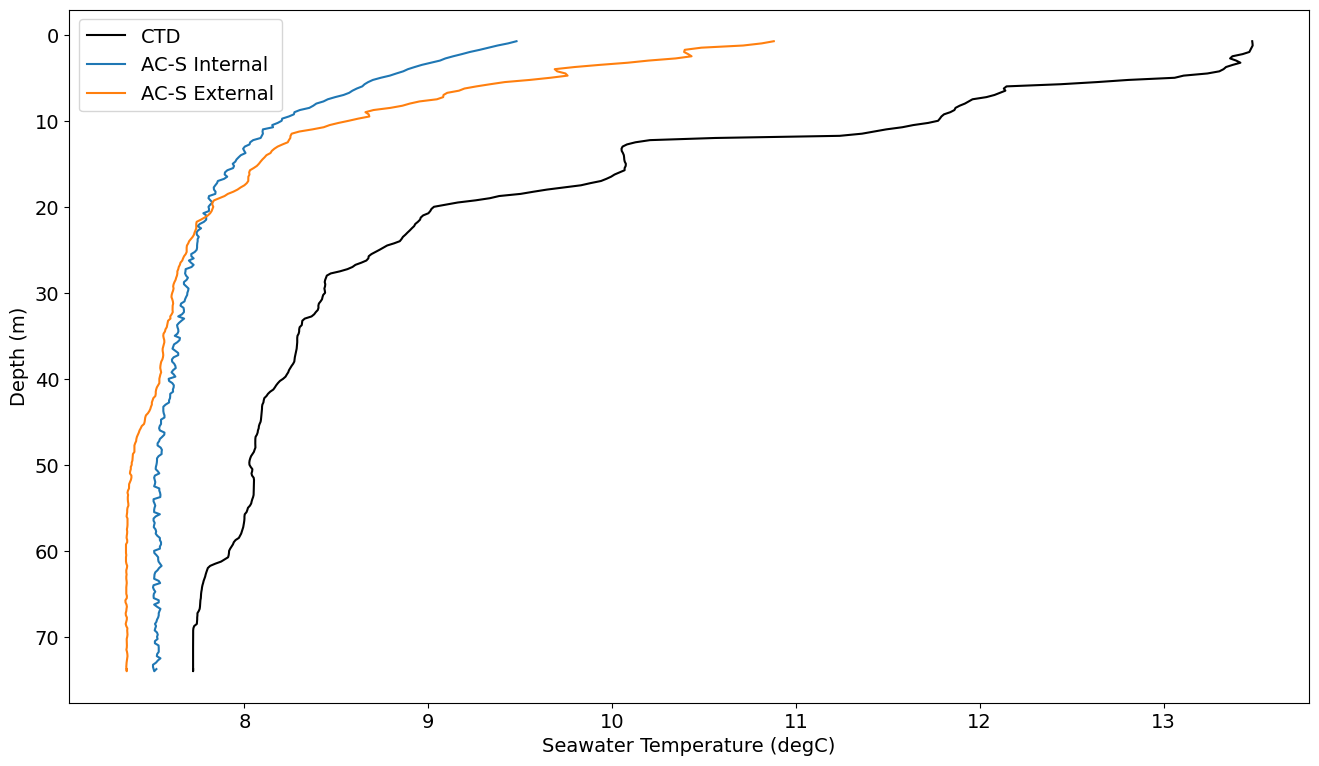

In [7]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 27
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['sea_water_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

In [8]:
%%time
import numpy as np
from ooi_data_explorations.uncabled.process_flort import flort_cspp

# Setup needed parameters for the request
sensor = '07-FLORTJ000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'recovered_cspp'   # OOI Net data delivery method
instrmt = 'flort'           # local directory name, instrument below level

# load data from the GC THREDDS Catalog
flort = load_gc_thredds(site, node, sensor, method, stream, ('deployment%04d.*FLORT.*\\.nc$' % deploy))
flort = flort_cspp(flort)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 53607 * (flort['bback'] - flort['sea_water_scattering_coefficient']) + 2.5  # derived from Cetinic et al., 2012 and references therein

# add the estimated chlorophyll and POC from the FLORT data to the AC-S data
chl = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_chlorophyll)
poc = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_poc)

optaa['fluorometric_chlorophyll'] = ('time', chl)
optaa['backscatter_poc'] = ('time', poc)
profiles = optaa.groupby('profile')
profile = profiles[27]

Merging the data files into a single dataset
Creating and adding a profile variable to the data set ...
CPU times: user 1.43 s, sys: 27.2 ms, total: 1.45 s
Wall time: 1.85 s


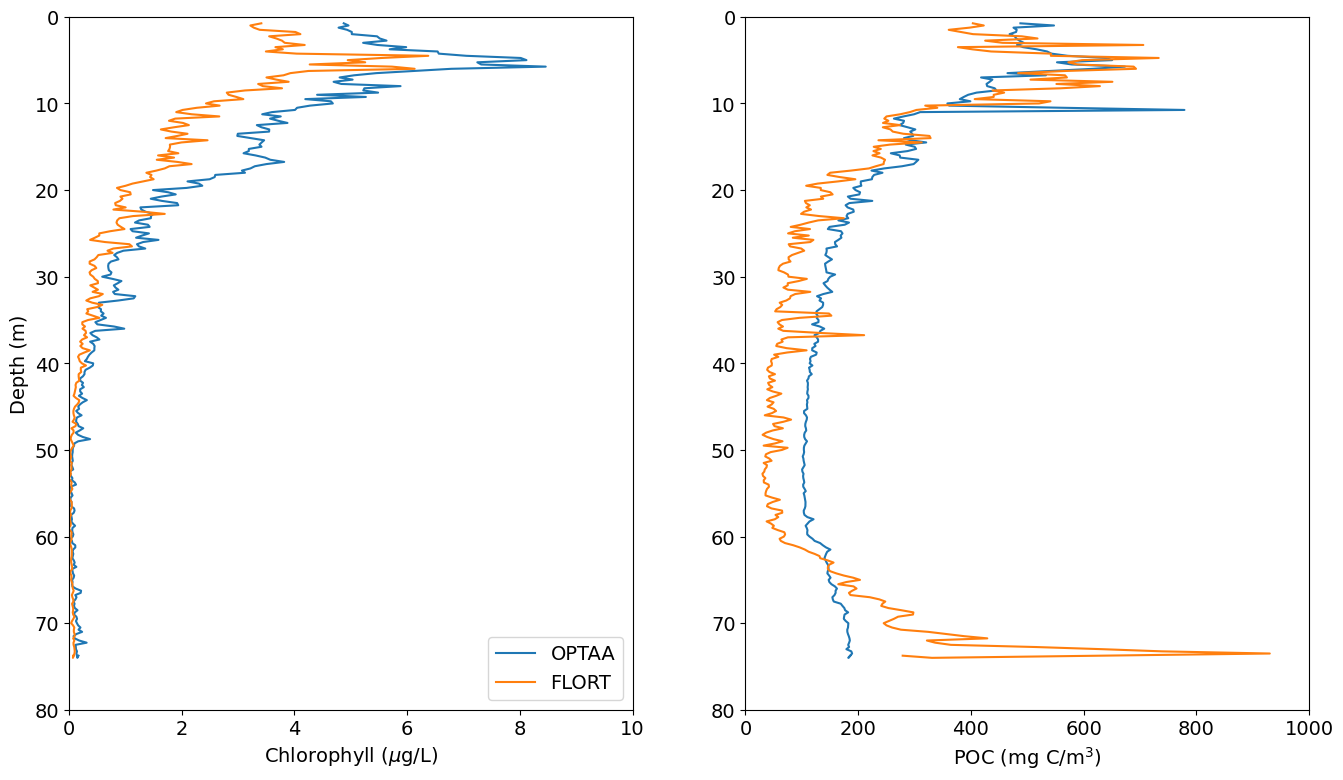

In [9]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(profile['fluorometric_chlorophyll'], profile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 10])
plt.ylim([0, 80])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(profile['backscatter_poc'], profile['depth'])
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 1000])
plt.ylim([0, 80])
plt.gca().invert_yaxis()
plt.show()

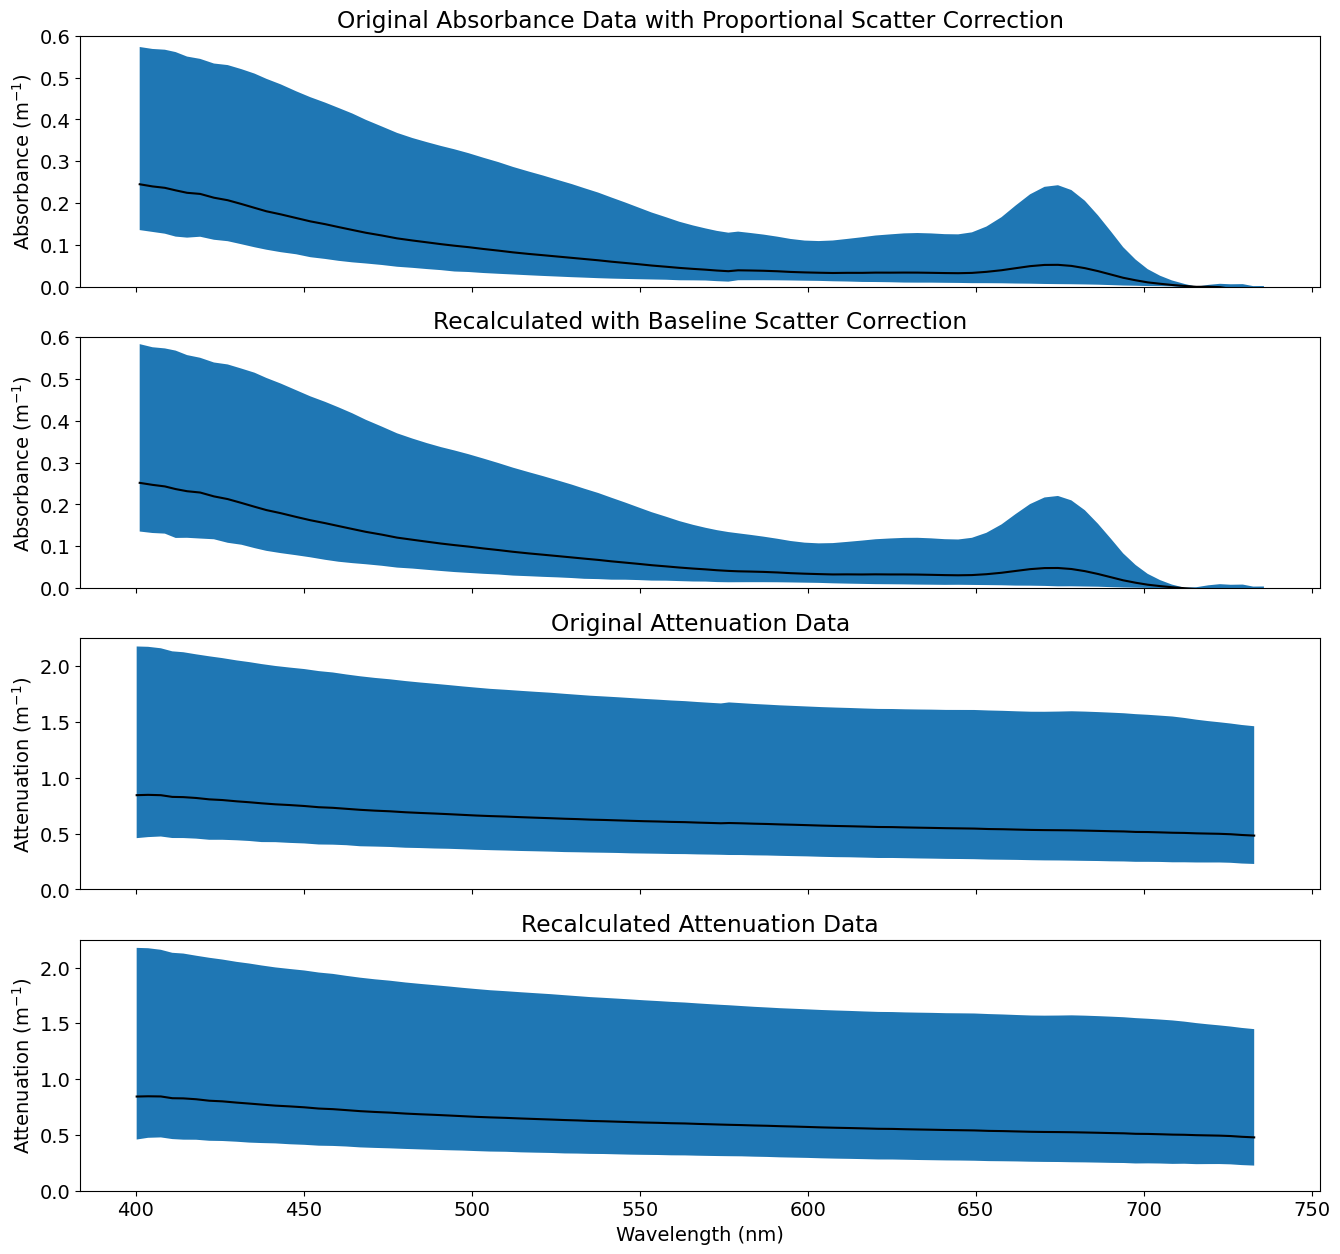

In [10]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message='Degrees of freedom <= 0 for slice.')


ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].mean(axis=0) + profile['optical_absorption'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data with Proportional Scatter Correction')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].mean(axis=0) + profile['apg_ts_s'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].mean(axis=0) + profile['beam_attenuation'].std(axis=0) * 3)
plt.ylim([0, 2.25])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.title('Original Attenuation Data')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpg_ts'].min(axis=0), 
                 profile['cpg_ts'].mean(axis=0) + profile['cpg_ts'].std(axis=0) * 3)
plt.ylim([0, 2.25])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Recalculated Attenuation Data')

plt.show()

In [11]:
# create a slice at 10 m for the entire deployment
slice10 = optaa.where((optaa['depth'] >= 9.75) & (optaa['depth'] <= 10.25), drop=True)

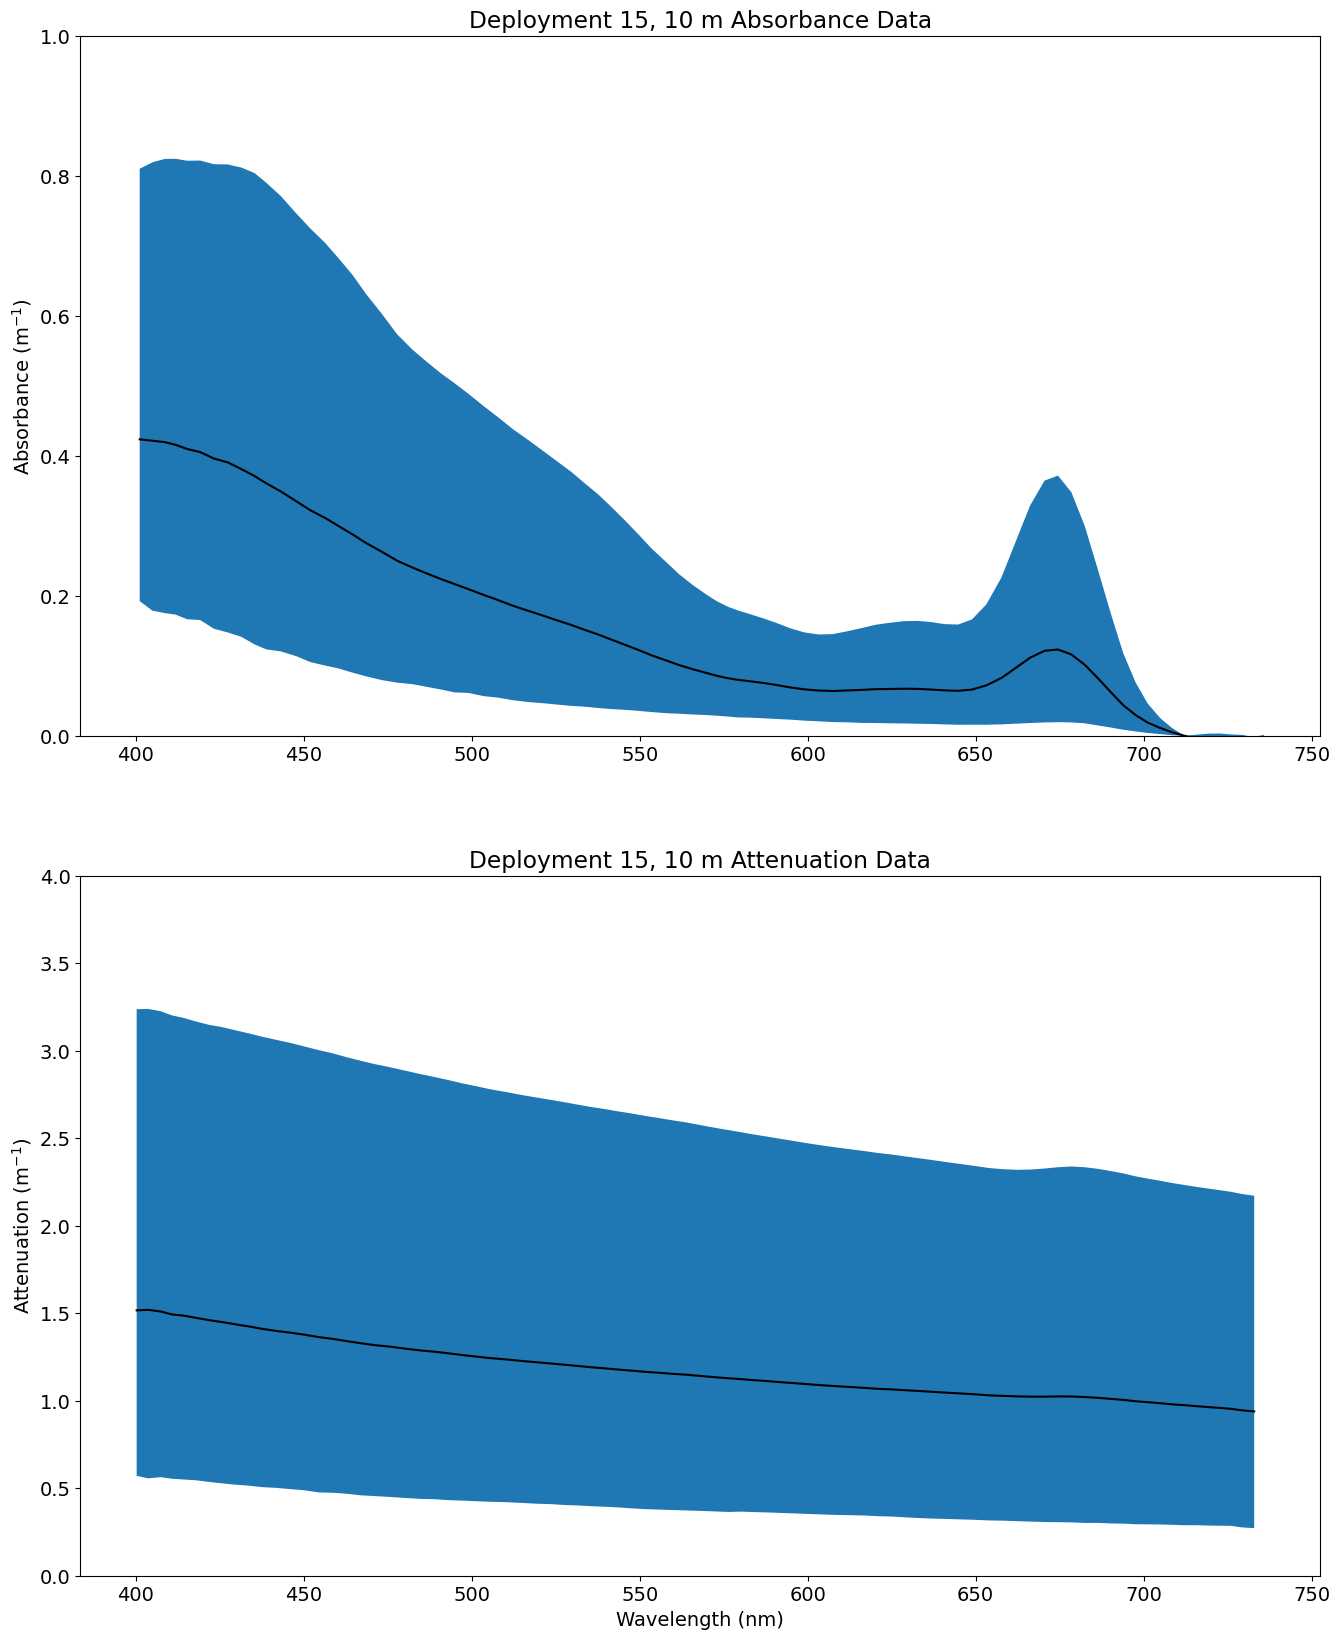

In [12]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].min(axis=0), 
                 slice10['apg_ts_s'].mean(axis=0) + (slice10['apg_ts_s'].std(axis=0) * 3))
plt.ylim([0, 1])
plt.title('Deployment 15, 10 m Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice10['wavelength_c'][0, :], slice10['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_c'][0, :], slice10['cpg_ts'].min(axis=0), 
                 slice10['cpg_ts'].mean(axis=0) + (slice10['cpg_ts'].std(axis=0) * 3))
plt.ylim([0, 4])
plt.title('Deployment 15, 10 m Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()